## Predicting fast growing firms 

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

warnings.filterwarnings("ignore")

In [2]:
sys.path.append("C:\\Users\\User\\Desktop\\Data Analysis 3\\Assignment_3\\Code")

In [3]:
from py_helper_functions import *

In [4]:
current_path = os.getcwd()
dirname = current_path.split("Code")[0]
Data = dirname + "\\Data"
output = dirname + "\\Output"

In [5]:
# Import data
data = pd.read_csv(output + "\\bisnode_firms_clean.csv")

In [6]:
data.shape

(16822, 114)

In [7]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,inc_bef_tax_pl_quad,profit_loss_year_pl_quad,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg
count,16822.0,1.682200e+04,1.682200e+04,1.682200e+04,1.682200e+04,16822.000000,1.682200e+04,1.682200e+04,1.682200e+04,1.682200e+04,...,16822.000000,16822.000000,16822.000000,16822.000000,16822.000000,16822.000000,16822.000000,16822.000000,16822.000000,16822.000000
mean,2012.0,1.535175e+11,1.020244e+04,1.077879e+05,9.015085e+04,425.671824,1.686843e+03,1.257217e+03,1.597126e+05,8.041229e+03,...,0.131790,0.119098,0.467982,46.797800,0.009868,0.004161,0.131732,0.261146,0.666470,0.132862
std,0.0,1.378124e+11,5.247282e+04,4.603151e+05,4.395143e+05,7155.227707,3.437689e+04,3.356701e+04,1.171108e+06,1.363609e+05,...,0.267546,0.257408,0.386204,10.380551,0.098850,0.064375,0.338210,0.439272,1.544521,0.339435
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-1.702444e+05,0.000000e+00,-1.091879e+07,...,0.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000
25%,2012.0,2.911829e+10,1.777778e+02,3.929630e+03,3.870370e+03,0.000000,0.000000e+00,0.000000e+00,3.370370e+02,-5.681481e+03,...,0.000711,0.000382,0.082238,39.000000,0.000000,0.000000,0.000000,0.000000,0.131944,0.000000
50%,2012.0,1.150385e+11,1.066667e+03,1.292963e+04,1.512963e+04,0.000000,0.000000e+00,0.000000e+00,6.051852e+03,4.074074e+02,...,0.010430,0.006628,0.394449,46.839205,0.000000,0.000000,0.000000,0.000000,0.310606,0.000000
75%,2012.0,2.564703e+11,4.691667e+03,4.471389e+04,5.035926e+04,0.000000,0.000000e+00,0.000000e+00,4.795463e+04,4.799074e+03,...,0.096563,0.074992,0.914296,54.000000,0.000000,0.000000,0.000000,1.000000,0.660444,0.000000
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,1.000000,1.000000,75.000000,1.000000,1.000000,1.000000,1.000000,42.118057,1.000000


In [8]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)
def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=seq(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n
    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=seq(0, 1.1, by=0.1))
        + scale_x_continuous(breaks=seq(0, 1.1, by=0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

#### Generate independent variable sets

In [9]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    "sales",
    "share_eq",
    "subscribed_cap",
]

In [10]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

In [11]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

In [12]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

In [13]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

In [14]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*sales_mil_log",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "sales_mil_log*age",
    "sales_mil_log*female",
    "sales_mil_log*profit_loss_year_pl",
    "sales_mil_log*foreign_management",
]

In [15]:
M1 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "Sales_growth",
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "sales_mil_log",
    "sales_mil_log_sq",
    "Sales_growth",
    "profit_loss_year_pl",
    "fixed_assets_bs", 
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = ["sales_mil_log", "sales_mil_log_sq", "Sales_growth"] + firm + engvar
M4 = (
    ["sales_mil_log", "sales_mil_log_sq", "Sales_growth"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)
M5 = (
    ["sales_mil_log", "sales_mil_log_sq", "Sales_growth"]
    + firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

In [16]:
logit_lasso_vars = (
    ["sales_mil_log", "sales_mil_log_sq", "Sales_growth"]
    + engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

In [17]:
rfvars = ["sales_mil"] + rawvars + hr + firm + qualityvars

#### Train and test split 

In [18]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [19]:
print("Total")
print(data["High_growth"].value_counts(normalize=True))
print("Train")
print(data_train["High_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["High_growth"].value_counts(normalize=True))

Total
0    0.860896
1    0.139104
Name: High_growth, dtype: float64
Train
0    0.860147
1    0.139853
Name: High_growth, dtype: float64
Holdout
0    0.863893
1    0.136107
Name: High_growth, dtype: float64


In [20]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### Logit model

In [21]:
logit_model_vars = [M1, M2, M3, M4, M5]

In [22]:
C_value_logit = [1e20]

In [23]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "High_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [24]:
# Logit Lasso Model
model_equation = "High_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

In [25]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

In [26]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

In [27]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

In [28]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000929,0.360978
1,0.046416,0.002001,0.348105
2,0.021544,0.004312,0.340308
3,0.010000,0.009289,0.335116
4,0.004642,0.020012,0.332883
5,0.002154,0.043115,0.332435
6,0.001000,0.092888,0.332621
7,0.000464,0.200122,0.333097
8,0.000215,0.431150,0.333463
9,0.000100,0.928885,0.333698


In [29]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

In [30]:
coef_lasso_mat=coef_matrix(normalized_logitvars, logit_models["LASSO"])
coef_lasso_mat["Importance"]=abs(coef_lasso_mat['coefficient'])
coef_lasso_mat=coef_lasso_mat.sort_values(by=['Importance'],  ascending=False )
coef_lasso_mat.head(10).to_csv(output +'\\lassocoef.csv')
coef_lasso_mat.head(10)

,variable,coefficient,Importance
143,Intercept,[-2.0189983329287524],[2.0189983329287524]
138,balsheet_notfullyear,-0.575295,0.575295
34,sales_mil_log_sq,0.304656,0.304656
26,sales_mil_log,-0.250889,0.250889
7,C(ind2_cat)[T.56.0],-0.187564,0.187564
119,age,-0.161779,0.161779
90,ceo_age,-0.138579,0.138579
135,new,0.135952,0.135952
5,C(ind2_cat)[T.33.0],0.119475,0.119475
48,material_exp_pl,0.118943,0.118943


In [31]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

In [32]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "High_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

In [33]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

In [34]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

### Random forest model

In [35]:
y_train, rfvars_train = patsy.dmatrices("High_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("High_growth~" + "+".join(rfvars), data_holdout)

<Figure size 640x480 with 0 Axes>

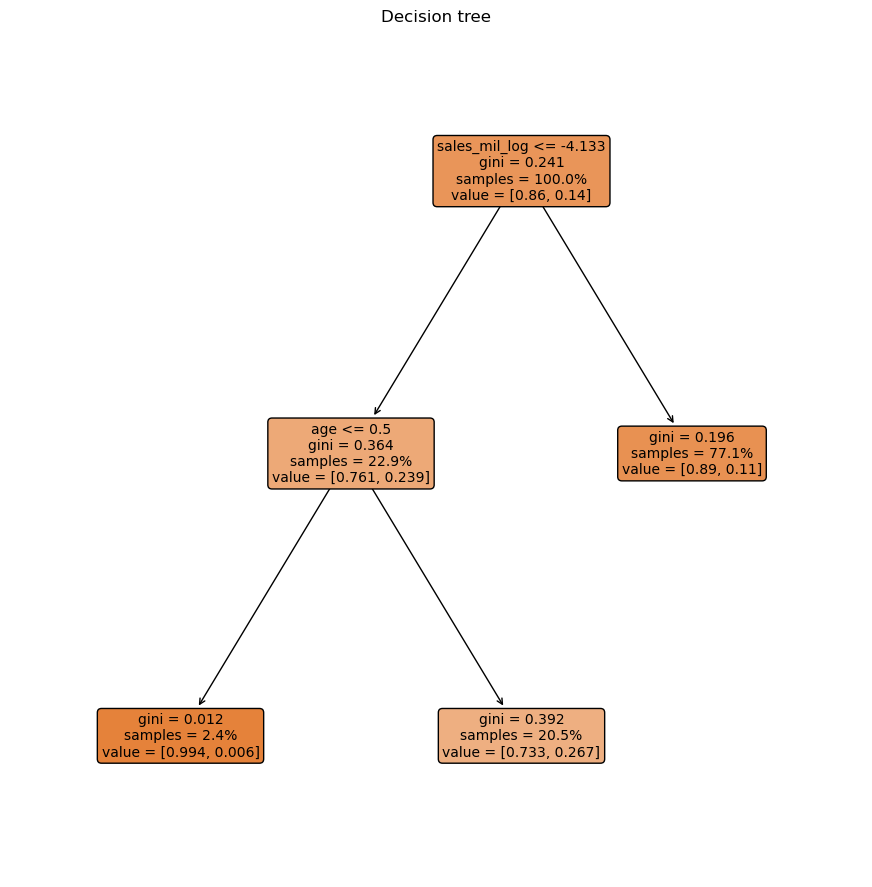

In [36]:
data_for_graph = data_train[["sales_mil_log", "age", "female"]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()

In [37]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

In [38]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [39]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

In [40]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.715432,0.332513
1,5,16,0.717473,0.332119
2,6,11,0.714199,0.332794
3,6,16,0.717421,0.332380
4,7,11,0.714597,0.332910
5,7,16,0.715730,0.332686


In [41]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_

{'criterion': 'gini', 'max_features': 5, 'min_samples_split': 16}

In [42]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [43]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]

In [44]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,12.0,0.340415,0.649101
M2,19.0,0.339111,0.667022
M3,33.0,0.339367,0.664183
M4,76.0,0.333711,0.701493
M5,143.0,0.333170,0.706208
LASSO,68.0,0.332403,0.709634
RF,n.a.,0.332119,0.717473


### Prediction

In [45]:
best_logit = logit_models["M4"]
model_equation = "High_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

In [46]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["High_growth"]), 3)

0.33

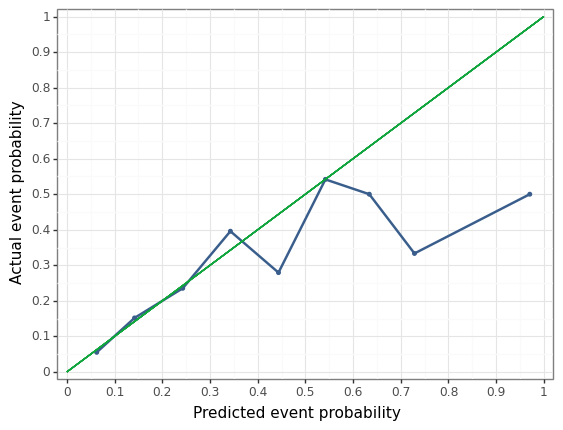

<ggplot: (133144570140)>

In [47]:
prediction= create_calibration_plot(
    data_holdout,
    file_name="Logit-M4",
    prob_var="best_logit_pred_proba",
    actual_var="High_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)
ggsave(prediction, filename=output +'\\predict.png', dpi=1000)
prediction

In [48]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (no High_growth): ", counts[0])
print(values[1], " (High_growth): ", counts[1])

0.0  (no High_growth):  3324
1.0  (High_growth):  41


In [49]:
cm_object1 = confusion_matrix(
    data_holdout["High_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actul no High_growth", "Actual High_growth"],
    columns=["Predicted no High_growth", "Predicted High_growth"],
)
cm1

,Predicted no High_growth,Predicted High_growth
Actul no High_growth,2887,20
Actual High_growth,437,21


In [50]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.25, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["High_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actul no High_growth", "Actual High_growth"],
    columns=["Predicted no High_growth", "Predicted High_growth"],
)
cm1b

,Predicted no High_growth,Predicted High_growth
Actul no High_growth,2637,270
Actual High_growth,310,148


In [51]:
mean_predicted_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_prob, 3)

0.139

In [52]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["High_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actul no High_growth", "Actual High_growth"],
    columns=["Predicted no High_growth", "Predicted High_growth"],
)
cm2

,Predicted no High_growth,Predicted High_growth
Actul no High_growth,1948,959
Actual High_growth,166,292


In [53]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["High_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [54]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

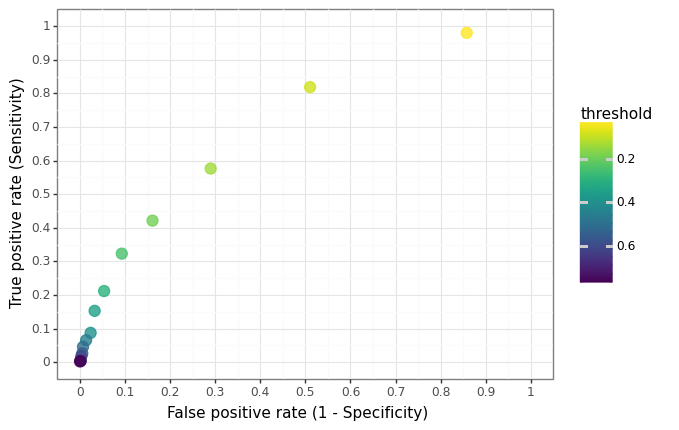

<ggplot: (133144746268)>

In [55]:
sensitivity= (
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)
ggsave(sensitivity, filename=output +'\\sensitivity.png', dpi=1000)
sensitivity

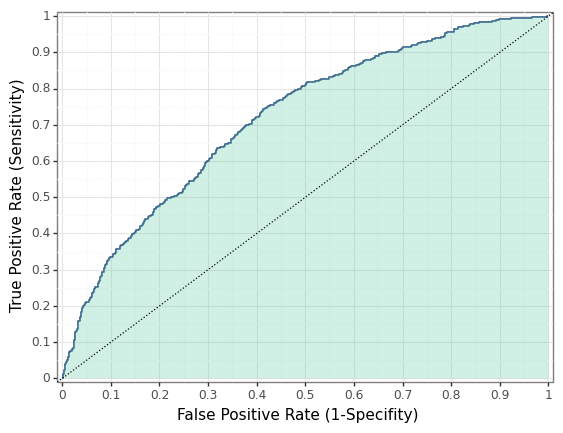

<ggplot: (133144890245)>

In [56]:
create_roc_plot(data_holdout["High_growth"], data_holdout["best_logit_pred_proba"])

### Classification by using loss function 

In [57]:
FP = 4
FN = 3
cost = FN / FP

In [58]:
prevelance = y_train.sum() / len(y_train)

In [59]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("High_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["High_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [60]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()

In [61]:
summary_with_lossfnc.to_csv(output +'\\table.csv')
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.665775,0.437027,0.417550,0.417689
1,M2,0.746741,1.623098,0.418368,0.423634
2,M3,0.948112,0.480825,0.418293,0.421033
3,M4,0.502432,0.489833,0.412423,0.419175
4,M5,0.600458,0.691180,0.412348,0.420290
5,LASSO,0.513219,0.507251,0.413017,0.415831


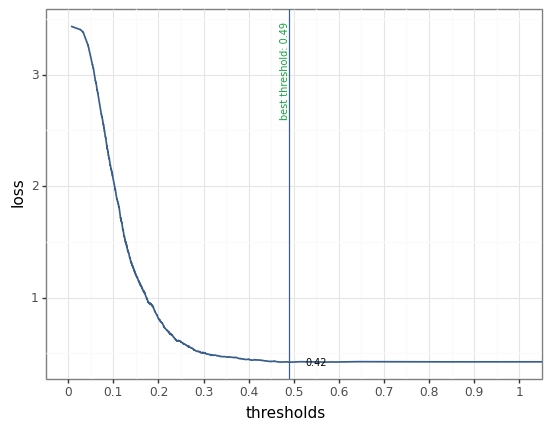

<ggplot: (133145940502)>

In [62]:
model_to_plot = "M4"  # select model to plot
loss= create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)
ggsave(loss, filename=output +'\\loss.png', dpi=1000)
loss

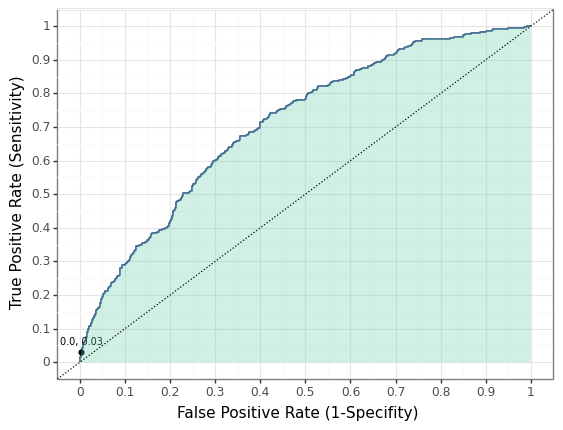

<ggplot: (133150365980)>

In [63]:
roc_cur=create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)
ggsave(roc_cur, filename=output +'\\roc_cur.png', dpi=1000)
roc_cur

In [64]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["High_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["High_growth"])
round(expected_loss_holdout, 3)

0.413

In [65]:
cm_object3 = confusion_matrix(data_holdout["High_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no High_growth", "Actual High_growth"],
    columns=["Predicted no High_growth", "Predicted High_growth"],
)
cm3.to_csv(output +'\\model.csv')
cm3

,Predicted no High_growth,Predicted High_growth
Actul no High_growth,2887,20
Actual High_growth,437,21


In [66]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["High_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["High_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)

In [67]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)

In [68]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.332,0.717,0.954,1.644,0.416,0.424


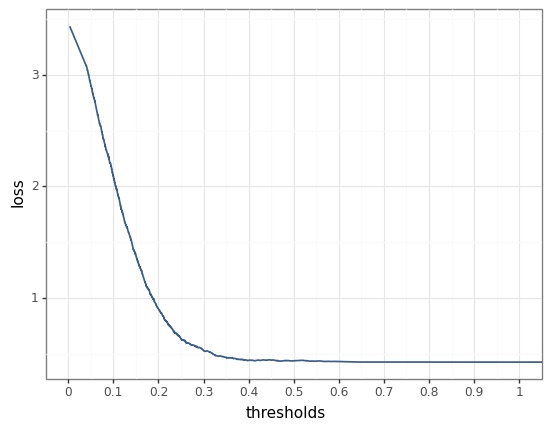

<ggplot: (133144725508)>

In [69]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

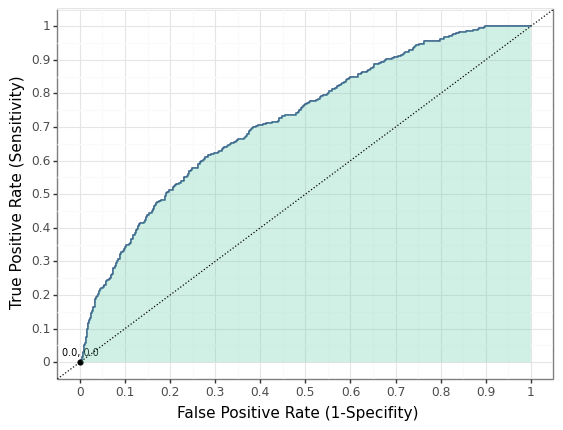

<ggplot: (133150512743)>

In [70]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

In [71]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)

0.327

In [72]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)

0.734

In [73]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)

0.408

In [74]:
summary["CV treshold"] = best_thresholds_cv.values()
summary["CV expected Loss"] = expected_loss_cv.values()

In [75]:
summary.to_csv(output +'\\last.csv')
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,12.0,0.340415,0.649101,0.665775,0.417550
M2,19.0,0.339111,0.667022,0.746741,0.418368
M3,33.0,0.339367,0.664183,0.948112,0.418293
M4,76.0,0.333711,0.701493,0.502432,0.412423
M5,143.0,0.333170,0.706208,0.600458,0.412348
LASSO,68.0,0.332403,0.709634,0.513219,0.413017
RF,n.a.,0.332119,0.717473,0.953849,0.415693


### Second classification 

In [89]:
FP = 1
FN = 5
cost = FN / FP

In [90]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("High_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["High_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [91]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5 2"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss 2"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5 2"] = fold5_expected_loss.values()

In [92]:
summary_with_lossfnc.to_csv(output +'\\tablenew.csv')
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5 2,Avg expected loss 2,Expected loss for Fold5 2
0,M1,0.151649,0.151479,0.588241,0.574136
1,M2,0.158768,0.159465,0.574569,0.571163
2,M3,0.155255,0.154201,0.572488,0.591230
3,M4,0.168674,0.152158,0.533699,0.535489
4,M5,0.159513,0.140306,0.523296,0.523969
5,LASSO,0.173725,0.168402,0.526343,0.532516


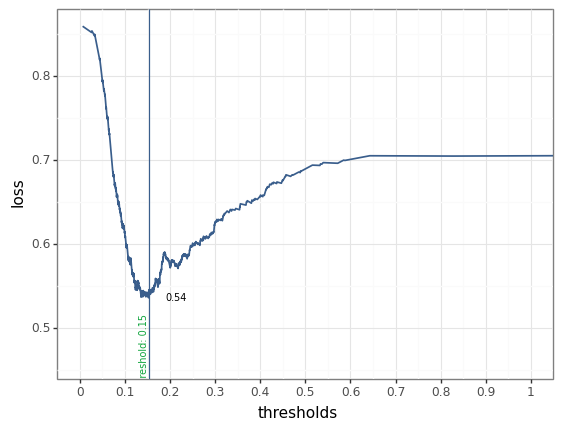

<ggplot: (133150839065)>

In [93]:
model_to_plot = "M4"  # select model to plot
loss= create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)
ggsave(loss, filename=output +'\\loss_new.png', dpi=1000)
loss

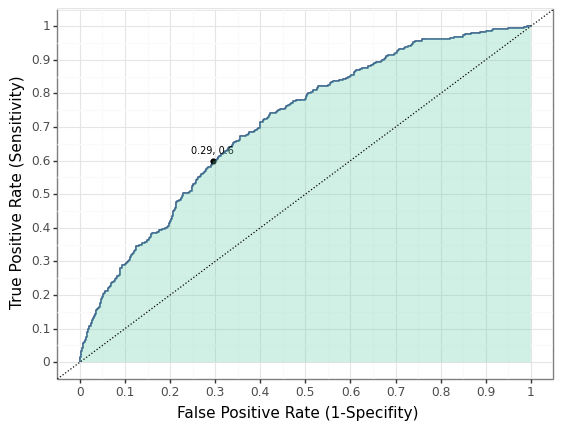

<ggplot: (133150412042)>

In [94]:
roc_cur=create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)
ggsave(roc_cur, filename=output +'\\roc_cur_new.png', dpi=1000)
roc_cur

In [95]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["High_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["High_growth"])
round(expected_loss_holdout, 3)

0.538

In [96]:
cm_object3 = confusion_matrix(data_holdout["High_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actul no High_growth", "Actual High_growth"],
    columns=["Predicted no High_growth", "Predicted High_growth"],
)
cm3.to_csv(output +'\\model_new.csv')
cm3

,Predicted no High_growth,Predicted High_growth
Actul no High_growth,2233,674
Actual High_growth,227,231
